# SVM classification of Donovan Mitchell #
Let's see where a model classifies donovan: All-star, All-NBA (1, 2, or 3), or MVP

In [1]:
# imports and setup
import scipy as sc
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import statsmodels.formula.api as sm
from sklearn import linear_model
from sklearn import svm, metrics
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)

# NOTE: SVM Models take 20+ minutes to complete running. Leave this switch to false to view previous results:
rerun = False

In [2]:
df_all = pd.read_csv('Data/Player-stats/Cleaned-dataframe')

# drop the unnamed column
df_all = df_all.drop(df_all.columns[0], 1)
df_all.head(15)

,Season,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,Name,All Star,MVP,All NBA
0,1992-93,24.0,TOT,NBA,PF,75.0,52.0,17.5,3.3,6.3,...,0.4,0.3,0.3,1.3,2.5,7.7,Alaa Abdelnaby,0.0,0,0
1,1994-95,26.0,TOT,NBA,PF,54.0,0.0,9.4,2.2,4.3,...,0.2,0.3,0.2,0.8,1.9,4.7,Alaa Abdelnaby,0.0,0,0
2,1981-82,34.0,LAL,NBA,C,76.0,76.0,35.2,9.9,17.1,...,3.0,0.8,2.7,3.0,2.9,23.9,Kareem Abdul-Jabbar,1.0,0,0
3,1982-83,35.0,LAL,NBA,C,79.0,79.0,32.3,9.1,15.5,...,2.5,0.8,2.2,2.5,2.8,21.8,Kareem Abdul-Jabbar,1.0,0,2
4,1983-84,36.0,LAL,NBA,C,80.0,80.0,32.8,9.0,15.5,...,2.6,0.7,1.8,2.8,2.6,21.5,Kareem Abdul-Jabbar,1.0,0,1
5,1984-85,37.0,LAL,NBA,C,79.0,79.0,33.3,9.2,15.3,...,3.2,0.8,2.1,2.5,3.0,22.0,Kareem Abdul-Jabbar,1.0,0,2
6,1985-86,38.0,LAL,NBA,C,79.0,79.0,33.3,9.6,16.9,...,3.5,0.8,1.6,2.6,3.1,23.4,Kareem Abdul-Jabbar,1.0,0,1
7,1986-87,39.0,LAL,NBA,C,78.0,78.0,31.3,7.2,12.7,...,2.6,0.6,1.2,2.4,3.1,17.5,Kareem Abdul-Jabbar,1.0,0,0
8,1987-88,40.0,LAL,NBA,C,80.0,80.0,28.9,6.0,11.3,...,1.7,0.6,1.2,2.0,2.7,14.6,Kareem Abdul-Jabbar,1.0,0,0
9,1988-89,41.0,LAL,NBA,C,74.0,74.0,22.9,4.2,8.9,...,1.0,0.5,1.1,1.3,2.6,10.1,Kareem Abdul-Jabbar,1.0,0,0


In [3]:
# A function that develops, optimizes, and tests an SVM model

def dev_test_svm(X, y, svm_name, max_c=150, test_size=0.4):
    # Cross-val function to find the best c-value.
    Cs = range(1, max_c, 1)
    acc_list = np.zeros(len(Cs))

    for ii, val in enumerate(Cs):
        svm_optimize = svm.SVC(kernel='rbf', C=val)
        scores = cross_val_score(estimator=svm_optimize, X=X, y=y, cv=5, scoring='accuracy')
        acc_list[ii] = scores.mean()

    plt.plot(Cs, acc_list)
    plt.xlabel('C-value')
    plt.ylabel('Accuracy')
    plt.show()

    # Identify maximum C value
    np.max(acc_list)
    max_C_index = np.where(acc_list == np.max(acc_list))[0][0]
    max_C = Cs[max_C_index]
    print('Best C Value: ', max_C)
    
    # Create an SVM model using the ideal C value

    # Split data into test and training values
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=test_size)

    # Train an SVM model
    if svm_name == 'all':
        svm_all = svm.SVC(kernel='rbf', C=max_C)
    elif svm_name == 'playoffs':
        svm_playoff = svm.SVC(kernel='rbf', C=max_C)
    else:
        svm_conf_semi = svm.SVC(kernel='rbf', C=max_C)
        
    
    # Train Model
    if svm_name == 'all':
        svm_all.fit(X_train, y_train)
    elif svm_name == 'playoffs':
        svm_playoff.fit(X_train, y_train)
    else:
        svm_conf_semi.fit(X_train, y_train)
        
    # Test Model
    if svm_name == 'all':
        print('svm_all')
        pred = svm_all.predict(X_test)
    elif svm_name == 'playoffs':
        print('playoffs')
        pred = svm_playoff.predict(X_test)
    else:
        print('conference semi')
        pred = svm_conf_semi.predict(X_test)
        
    print('Confusion Matrix:\n', metrics.confusion_matrix(y_true = y_test, y_pred = pred))
    print('Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = pred))
    return svm_all

In [ ]:
# Develop a classification model for players awards
# First, create a true column that represents all endd of season awards (all-star is lowest and MVP is highest in heirarchy)
df_all['True'] = 0
df_all['True']
df_all.loc[(df_all['All Star'] == 1), 'True'] = 1
df_all.loc[(df_all['All NBA'] == 3), 'True'] = 2
df_all.loc[(df_all['All NBA'] == 2), 'True'] = 3
df_all.loc[(df_all['All NBA'] == 1), 'True'] = 4
df_all.loc[(df_all['MVP'] == 1), 'True'] = 5

# Exclude Donovan Mitchell's career
df_spida = df_all.loc[df_all['Name'] == 'Donovan Mitchell', :]
spida_index = df_all.loc[df_all['Name'] == 'Donovan Mitchell'].index
df_svm = df_all.drop(spida_index[0])

# Move stat data to an array
X_all = df_svm.loc[:, 'MP':'PTS'].values # NOTE: Don't include games played or games started to account for variations in season lengths
y_true = df_svm['True']

print(X_all, y_true)
# df_svm.loc[df_svm['True'] == 2].head(30)

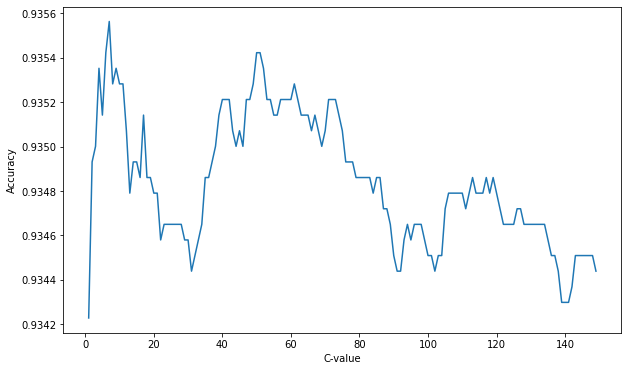

Best C Value:  7
svm_all
Confusion Matrix:
 [[5296    5    0    6    0    0]
 [ 149    7    0   13    6    0]
 [  49    1    0   11    2    0]
 [  39    4    0   18    8    0]
 [  19    4    0   16   22    0]
 [   4    0    0    3   11    0]]
Accuracy =  0.9385209906903215


In [21]:
# Evaluate SVM
if rerun:
    svm_all = dev_test_svm(X_all, y_true, 'all')

[0.997927265875259, 0.04, 0.0, 0.2608695652173913, 0.36065573770491804, 0.0]


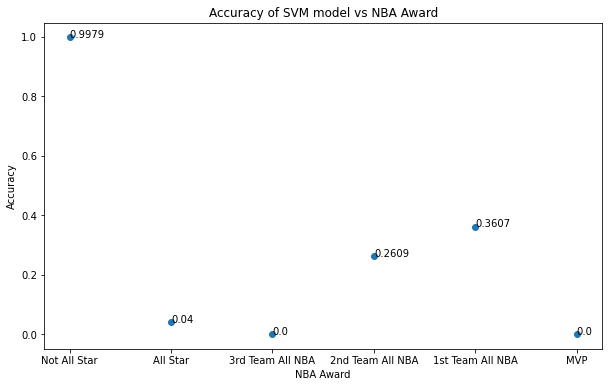

In [22]:
# Plot the results of the confusion matrix
plot_data= {'Not All Star': 5296/(5296+5+6), 'All Star': 7/(149+7+13+6), '3rd Team All NBA': 0/(49+1+11+2), '2nd Team All NBA':18/(39+4+18+8),
            '1st Team All NBA': 22/(19+4+16+22), 'MVP':0/(4+3+11)}
names = list(plot_data.keys())
values = list(plot_data.values())
print(values)
fig, ax = plt.subplots ()
ax.scatter(names, values)
for i, txt in enumerate(values):
    ax.annotate(float("{:.4f}".format(txt)), (names[i], values[i]))
plt.ylabel('Accuracy')
plt.xlabel('NBA Award')
plt.title('Accuracy of SVM model vs NBA Award')
plt.show()

**Comments:**
The above plot shows the SVM model, while exhibiting an overall accuracy of 94%, really works best on predicting which players won't be all stars. This may be explained the disparity in data for players receiving NBA awards. For example, about 400 players play in the NBA each season, but only one player receives the MVP award. So, while the dataset contains stats for thousands of players, it only contains data for 35 or so MVPs. 
<br>

Another line of reasoning suggests that the final awards are more of a popularity contest or politcaly motivated than based on pure statsitical performance. Many players would agree with this obseervation. 

In [8]:
# Evaluate SVM all on Donovan Mitchell
spida_18 = df_spida.loc[df_spida['Season'] == '2017-18', 'MP':'PTS'].values
spida_true_18 = df_spida.loc[df_spida['Season'] == '2017-18', 'True']
spida_19 = df_spida.loc[df_spida['Season'] == '2018-19', 'MP':'PTS'].values
spida_true_19 = df_spida.loc[df_spida['Season'] == '2018-19', 'True']
spida_20 = df_spida.loc[df_spida['Season'] == '2019-20', 'MP':'PTS'].values
spida_true_20 = df_spida.loc[df_spida['Season'] == '2019-20', 'True']
spida_21 = df_spida.loc[df_spida['Season'] == '2020-21', 'MP':'PTS'].values
spida_true_21 = df_spida.loc[df_spida['Season'] == '2020-21', 'True']
print('2017-2018 Prediction: ', svm_all.predict(spida_18)[0], 'Actual: ', str(spida_true_18).split('   ')[1].split('N')[0])
print('2018-2019 Prediction: ', svm_all.predict(spida_19)[0], 'Actual: ', str(spida_true_19).split('   ')[1].split('N')[0])
print('2019-2020 Prediction: ', svm_all.predict(spida_20)[0], 'Actual: ', str(spida_true_20).split('   ')[1].split('N')[0])
print('2020-2021 Prediction: ', svm_all.predict(spida_21)[0], 'Actual: ', str(spida_true_21).split('   ')[1].split('N')[0])

2017-2018 Prediction:  0 Actual:   0

2018-2019 Prediction:  0 Actual:   0

2019-2020 Prediction:  0 Actual:   1

2020-2021 Prediction:  0 Actual:   1



**Comments** The above SVM predicts a player's performance based on post-season awards in a heirarchical order: not an all star, all star, 3rd Team All NBA, 2nd Team All NBA, 1st Team All NBA, MVP. 
<br>
The model predicted that Donovan Mitchell wouldn't be an all star (or better) during any of his four seasons (which is incorrect for his previous two seasons). 

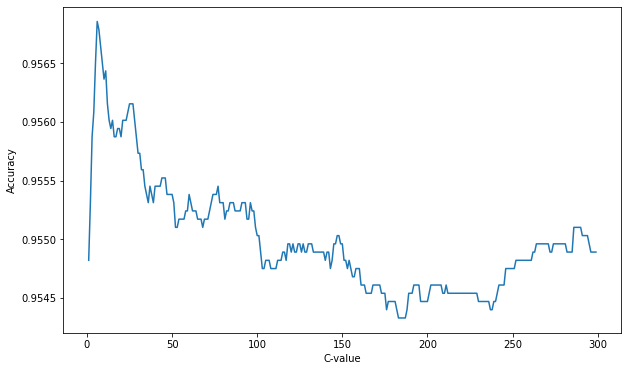

Best C Value:  6
svm_all
Confusion Matrix:
 [[4617   43]
 [ 159  163]]
Accuracy =  0.9594540345242875


In [9]:
# Try training an SVM to classify all-stars
X_all_star = df_all.loc[:, 'MP':'PTS'].values
y_all_star = df_all['All Star']

if rerun:
    svm_all_star = dev_test_svm(X_all_star, y_all_star, 'all', max_c=300, test_size=0.35)

[0.5590062111801242, 0.9901287553648068]


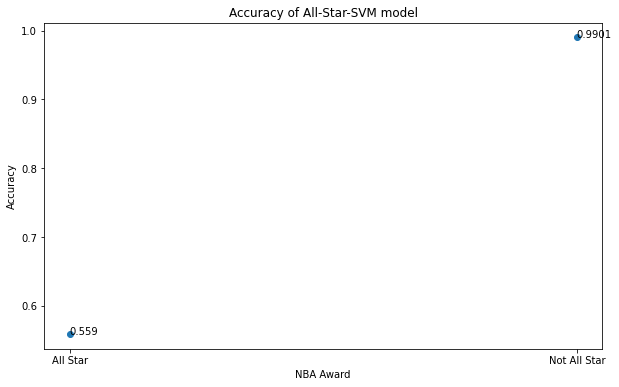

In [10]:
# Plot the results of the all-star SVM
plot_data= {'All Star': 180/(142 + 180), 'Not All Star': 4614/(4614+46)}
names = list(plot_data.keys())
values = list(plot_data.values())
print(values)
fig, ax = plt.subplots ()
ax.scatter(names, values)
for i, txt in enumerate(values):
    ax.annotate(float("{:.4f}".format(txt)), (names[i], values[i]))
plt.ylabel('Accuracy')
plt.xlabel('NBA Award')
plt.title('Accuracy of All-Star-SVM model')
plt.show()

**Comments:**
This model has a narrower scope: classifying all stars. It exhibits a very high accuracy for non all stars and a mediocre accuracy for all stars.

<br>
Possible explanations for this behavior are the same as stated for the above SVM (svm_all)

In [12]:
# Evaluate Don's career using the all-star svm
print('2017-2018 Prediction: ', svm_all_star.predict(spida_18)[0], 'Actual: ', str(spida_true_18).split('   ')[1].split('N')[0])
print('2018-2019 Prediction: ', svm_all_star.predict(spida_19)[0], 'Actual: ', str(spida_true_19).split('   ')[1].split('N')[0])
print('2019-2020 Prediction: ', svm_all_star.predict(spida_20)[0], 'Actual: ', str(spida_true_20).split('   ')[1].split('N')[0])
print('2020-2021 Prediction: ', svm_all_star.predict(spida_21)[0], 'Actual: ', str(spida_true_21).split('   ')[1].split('N')[0])

2017-2018 Prediction:  0.0 Actual:   0

2018-2019 Prediction:  0.0 Actual:   0

2019-2020 Prediction:  1.0 Actual:   1

2020-2021 Prediction:  1.0 Actual:   1



**Comments:**
The model correctly predicted Donovan Mitchell's career all star apperances!

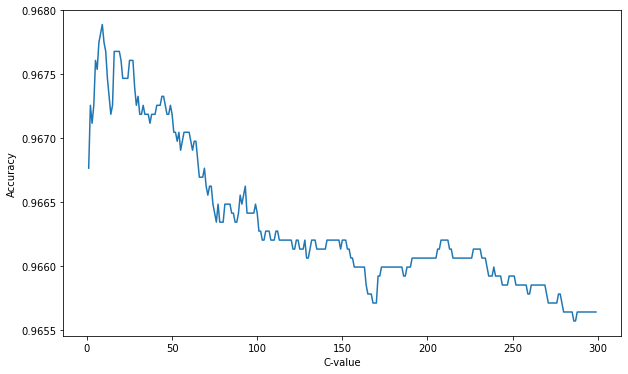

Best C Value:  9
svm_all
Confusion Matrix:
 [[4770    6    8    0]
 [  31   37    4    0]
 [  51    9   10    0]
 [  49    6    1    0]]
Accuracy =  0.9668807707747893


In [15]:
# Create an SVM model to predict all NBA award finalists
# Try training an SVM to classify all-stars
X_all_nba = df_all.loc[:, 'MP':'PTS'].values
y_all_nba = df_all['All NBA']

if rerun:
    svm_all_nba = dev_test_svm(X_all_nba, y_all_nba, 'all', max_c=300, test_size=0.35)

[0.9970735785953178, 0.5138888888888888, 0.14285714285714285, 0.0]


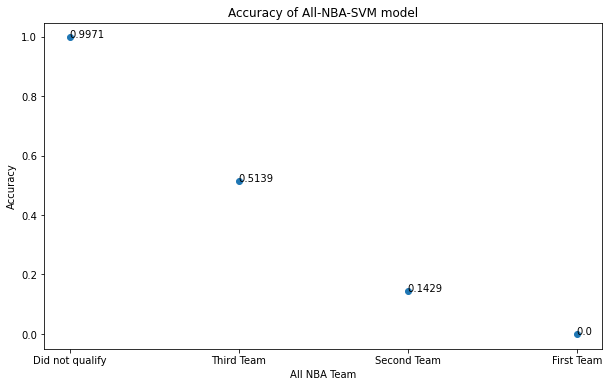

In [17]:
# Plot the results of the all-NBA SVM
plot_data= {'Did not qualify': 4770/(4770+6+8) , 'Third Team': 37/(31+37+4) , 'Second Team': 10/(51+9+10), 'First Team': 0/(49+6+1) }
names = list(plot_data.keys())
values = list(plot_data.values())
print(values)
fig, ax = plt.subplots ()
ax.scatter(names, values)
for i, txt in enumerate(values):
    ax.annotate(float("{:.4f}".format(txt)), (names[i], values[i]))
plt.ylabel('Accuracy')
plt.xlabel('All NBA Team')
plt.title('Accuracy of All-NBA-SVM model')
plt.show()

**Comments:**
This model follows in the same pattern as all previous models: it is much easier to predict players that do not receive awards than it is to predict award winners.

In [20]:
# Evaluate Don's career using the all NBA svm
print('2017-2018 Prediction: ', svm_all_nba.predict(spida_18)[0], 'Actual: ', 0)
print('2018-2019 Prediction: ', svm_all_nba.predict(spida_19)[0], 'Actual: ', 0)
print('2019-2020 Prediction: ', svm_all_nba.predict(spida_20)[0], 'Actual: ', 0)
print('2020-2021 Prediction: ', svm_all_nba.predict(spida_21)[0], 'Actual: ', 'TBD')

2017-2018 Prediction:  0 Actual:  0
2018-2019 Prediction:  0 Actual:  0
2019-2020 Prediction:  0 Actual:  0
2020-2021 Prediction:  0 Actual:  TBD


**Comments:** This model predicts that Donnovan will not be named to any of the All-NBA teams this year. Only time will tell if this prediction is accurate.